In [1]:
#Overview
    #First filter pairs based on correlation then select pairs using cointegration test, p-value
        #(I printed the pair with highest coint for my own interest)
        #also filtered based on list given and ensured pairs were not of same asset class
    #Then calculate spread
    #Then generate trade signals
    #Lastly calculate results for each pair, Sharpe ratio, to see which one had best performance

#Selecting pair by filtering pairs with correlation of >0.85 and then selecting based on coint
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
import warnings
from statsmodels.tools.sm_exceptions import CollinearityWarning
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Select a wide range of assets you're interested in
assets = ['ES=F', 'CL=F', 'GC=F', 'SI=F', 'AAPL', 'MSFT', 'GOOGL', 'AMZN', 
          'JPM', 'V', 'PG', 'XOM', 'GLD', 'SLV', 'USO', 'SPY', 'TLT', 'QQQ', 'DIA', 
          'NFLX', 'TSLA', 'BA', 'KO', 'DIS', 'PLUG', 'GS', 'IBM', 'INTC', 'ORCL', 'NVDA']

start_date = '2000-01-01'
end_date = '2021-12-31'

# Fetch the data for all assets
asset_data = []
asset_dict ={}
for i, asset in enumerate(assets):
    try:
        df = yf.download(asset, start=start_date, end=end_date)
        if not df.empty:  # If df is not empty
            df = df.resample('B').mean().fillna(method='ffill')  # Resample at daily frequency
            asset_data.append(df['Close'])
            asset_dict[asset] = i
    except Exception as e:
        print(f"Failed to download {asset}: {str(e)}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [2]:
# Testing period
test_start = '2000-01-01'
test_end = '2020-12-31'

# Perform analysis on each asset pair and select the pairs
selected_pairs = []
for i in range(len(asset_data)):
    for j in range(i+1, len(asset_data)):
        asset1 = asset_data[i].loc[test_start:test_end]
        asset2 = asset_data[j].loc[test_start:test_end]

        # Calculate correlation between asset1 and asset2
        correlation = asset1.corr(asset2)

        # If correlation > 0.70, perform cointegration analysis
        if correlation > 0.70:
            # Extract the closing prices of asset1 and asset2
            prices1 = asset1
            prices2 = asset2

            # Ensure prices1 and prices2 have the same length
            min_len = min(len(prices1), len(prices2))
            prices1 = prices1[:min_len]
            prices2 = prices2[:min_len]

            try:
                # Treat warnings as errors
                with warnings.catch_warnings():
                    warnings.simplefilter("error", category=CollinearityWarning)
                # Calculate the cointegration between asset1 and asset2
                    _, pvalue, _ = coint(prices1, prices2)
            except CollinearityWarning:
                # If a collinearity warning is thrown, skip this pair
                continue

            # Update the selected pairs with the cointegrated pairs
            selected_pairs.append((assets[i], assets[j], correlation, pvalue))

# Filter the selected pairs based on the cointegration test p-value
filtered_pairs = [pair for pair in selected_pairs if pair[3] < 0.05]

# Sort the filtered pairs based on p-values in ascending order
filtered_pairs.sort(key=lambda x: x[3])
# Print top 20 pairs
for i, pair in enumerate(filtered_pairs):
    print(f"Pair {i+1}: {pair[0]} and {pair[1]} with correlation {pair[2]} and p-value {pair[3]}")

Pair 1: KO and ORCL with correlation 0.9283410444771478 and p-value 0.00019832777359534912
Pair 2: MSFT and V with correlation 0.964415997744135 and p-value 0.00021373709100602618
Pair 3: MSFT and TSLA with correlation 0.7827422048057975 and p-value 0.0008424490692186408
Pair 4: MSFT and GOOGL with correlation 0.9347569068530501 and p-value 0.002173276734252411
Pair 5: GOOGL and AMZN with correlation 0.9559542849858841 and p-value 0.002825973633574358
Pair 6: JPM and DIA with correlation 0.9673457487758793 and p-value 0.002937369740002588
Pair 7: AMZN and V with correlation 0.9637768409421464 and p-value 0.005672389230141591
Pair 8: GOOGL and KO with correlation 0.8828040869620553 and p-value 0.005817215507500729
Pair 9: MSFT and NFLX with correlation 0.9678137442078302 and p-value 0.007791372847160778
Pair 10: ES=F and QQQ with correlation 0.9768981237696954 and p-value 0.010996154959283244
Pair 11: KO and DIS with correlation 0.9394953719791977 and p-value 0.01154217841096186
Pair 12

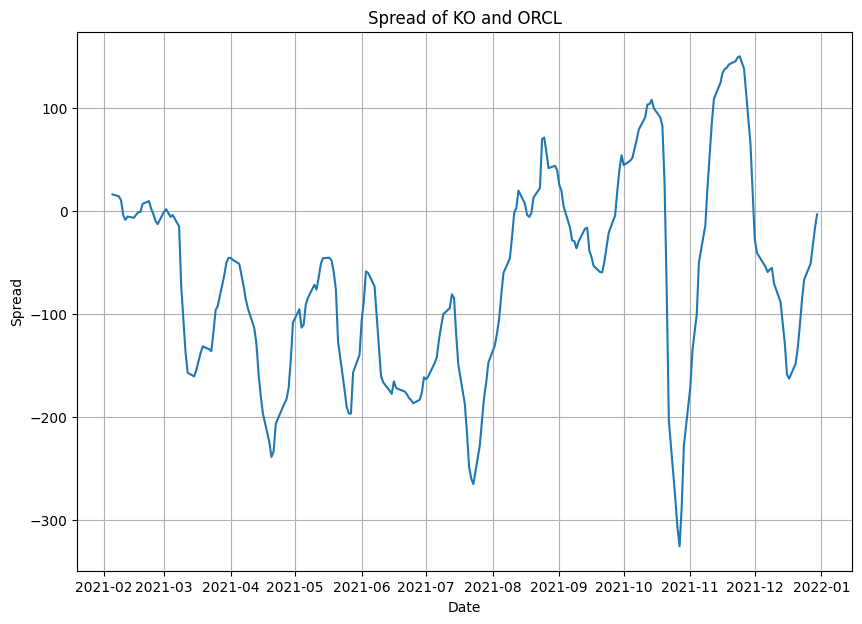

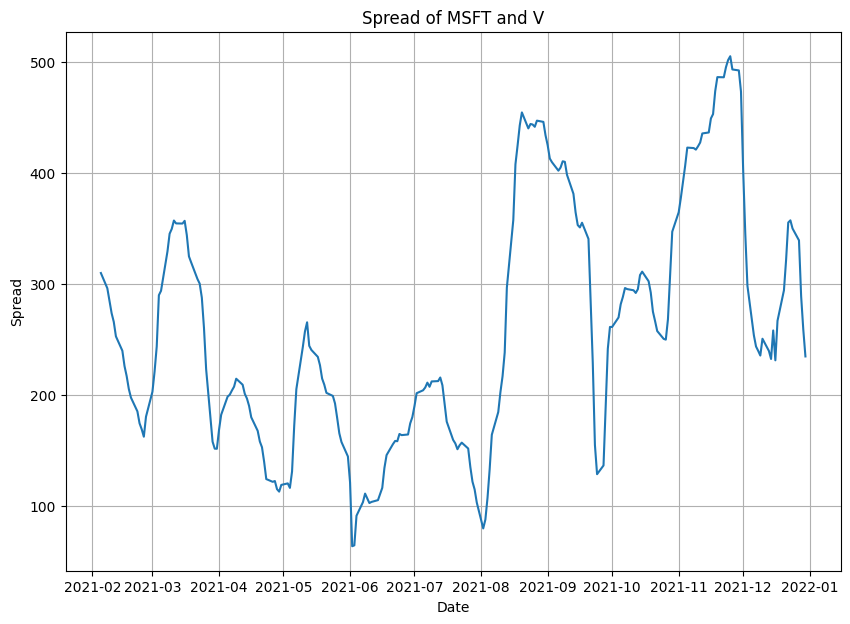

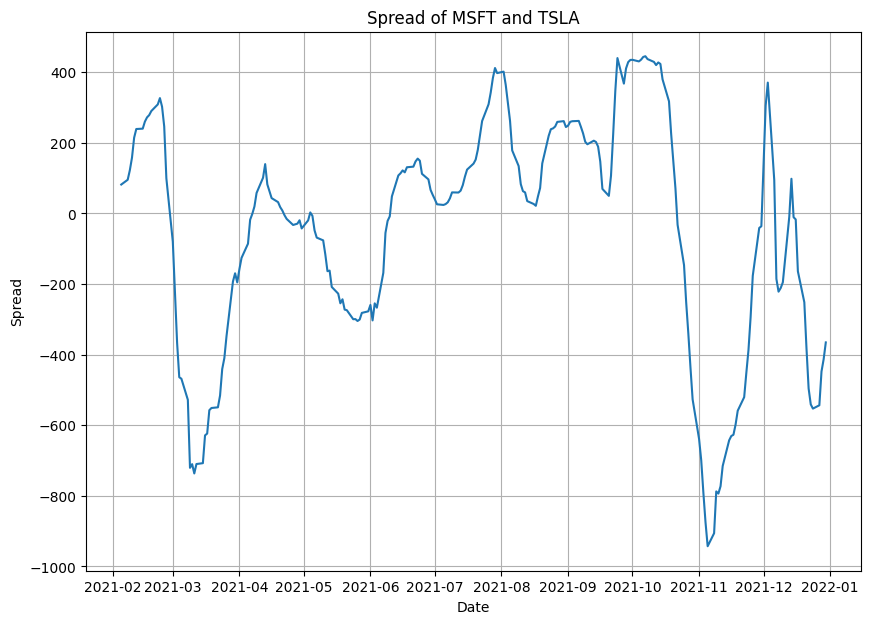

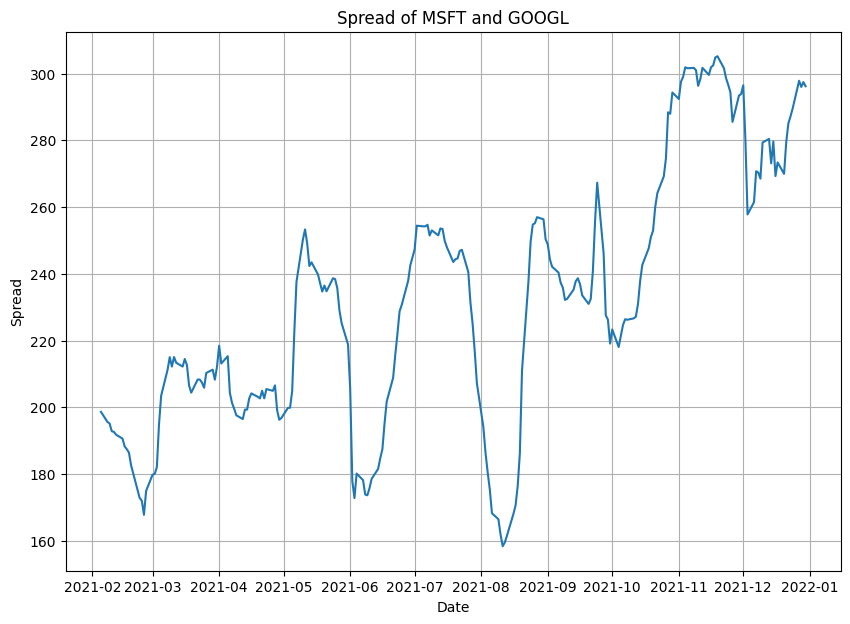

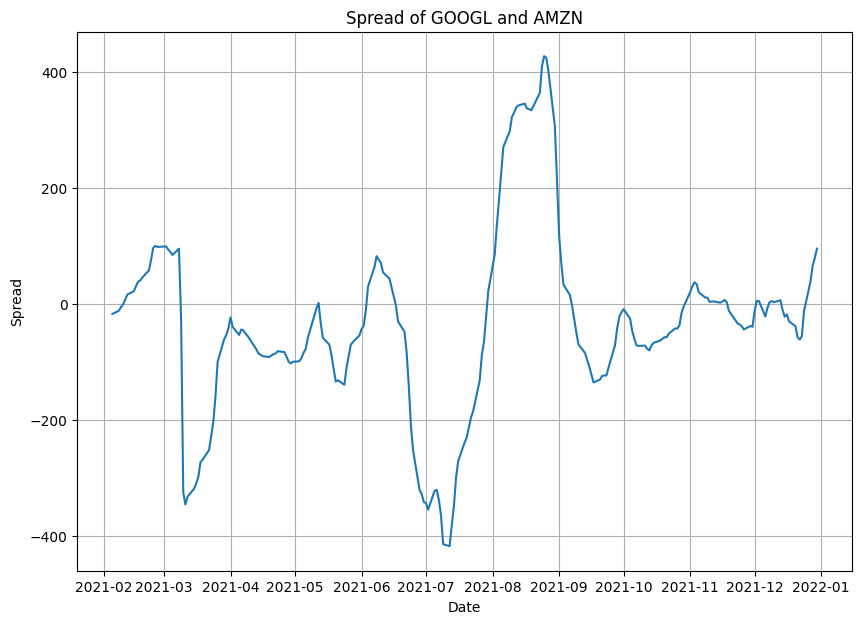

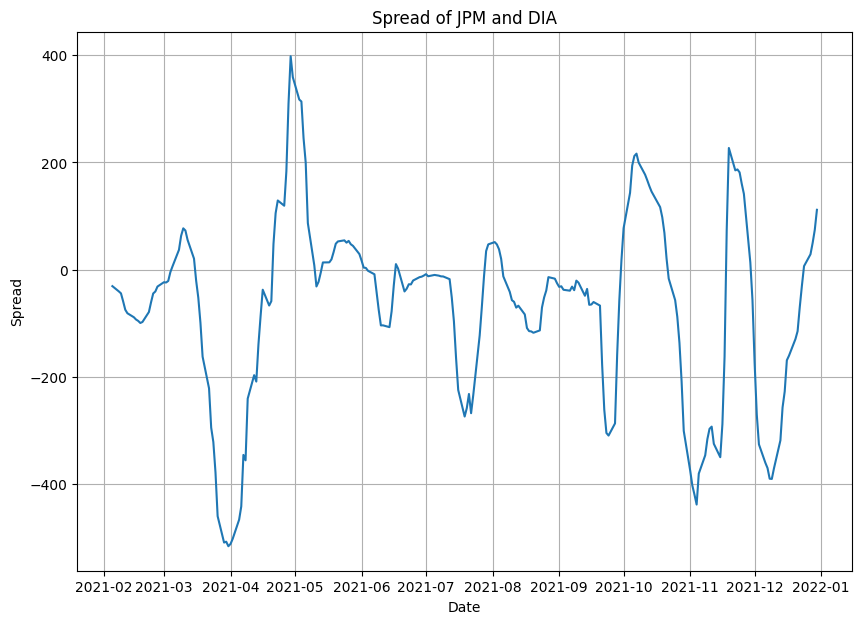

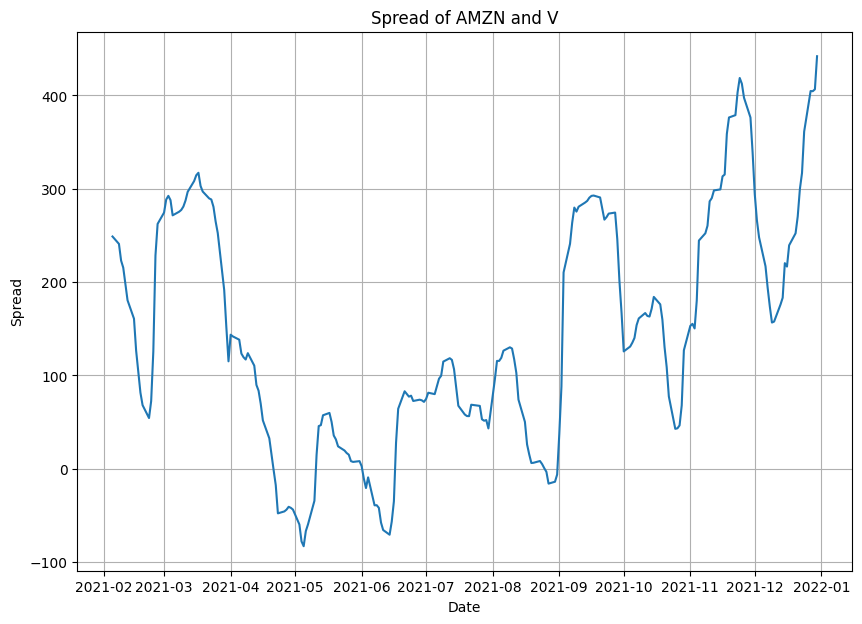

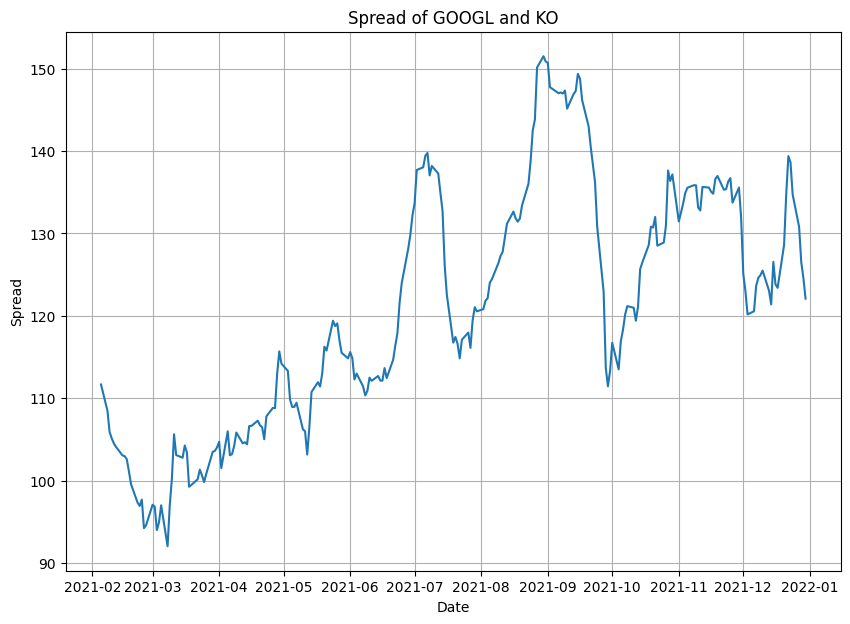

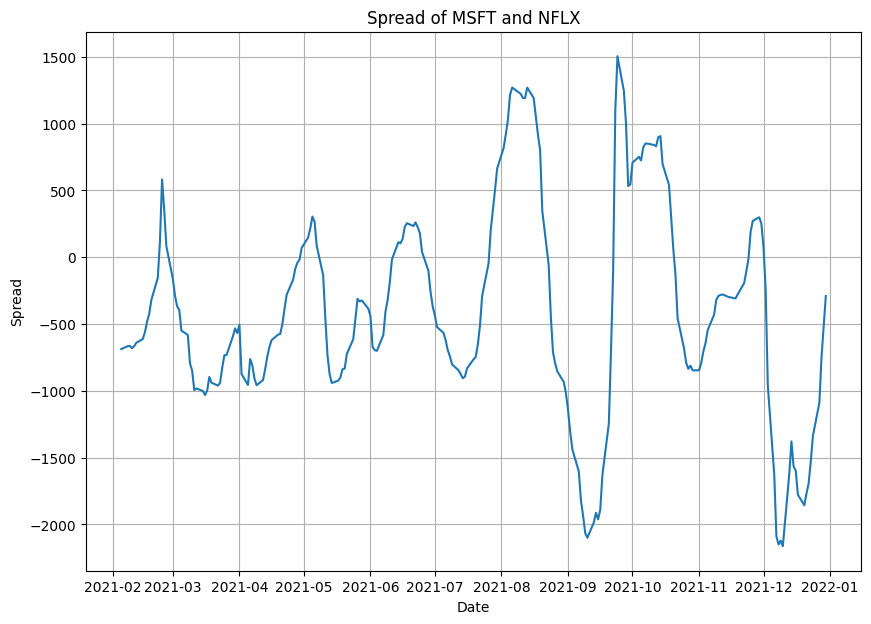

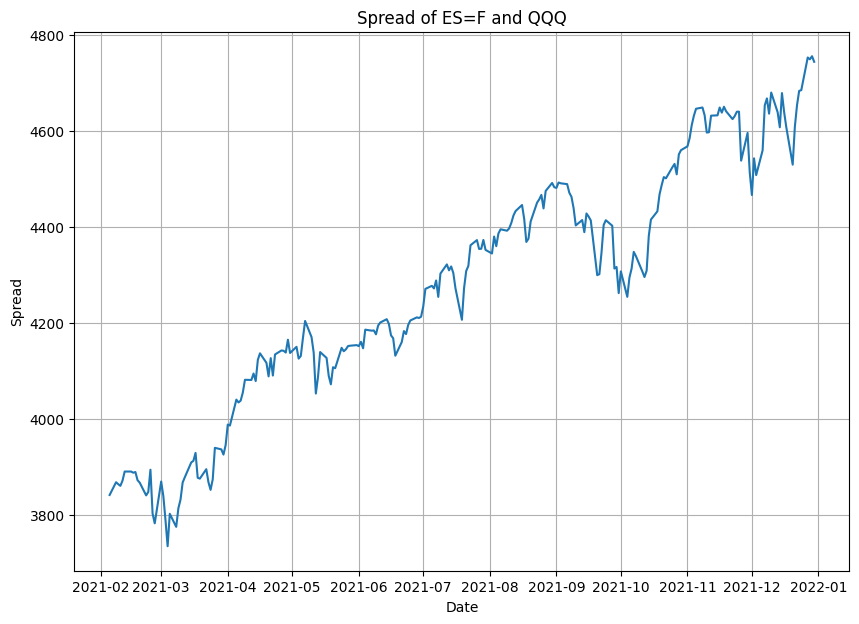

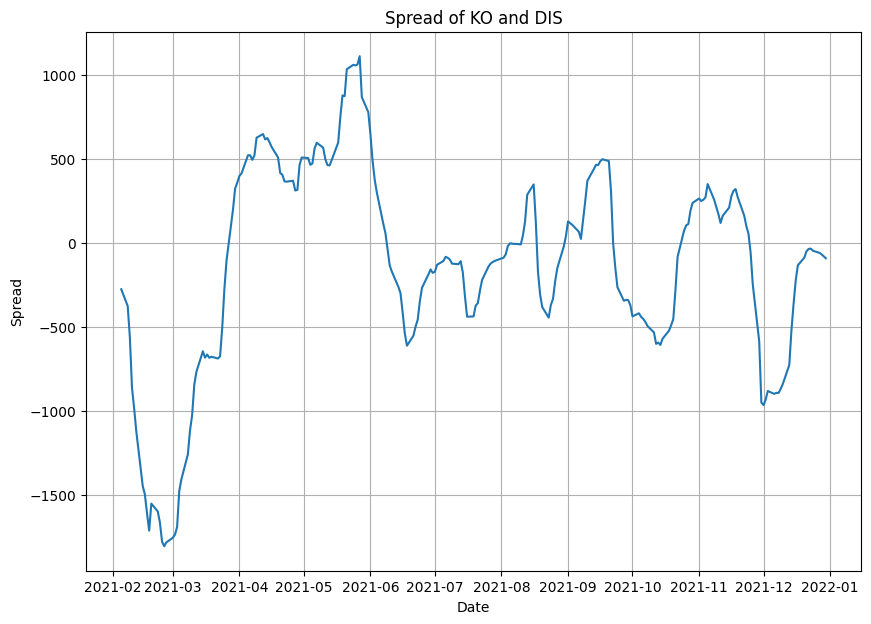

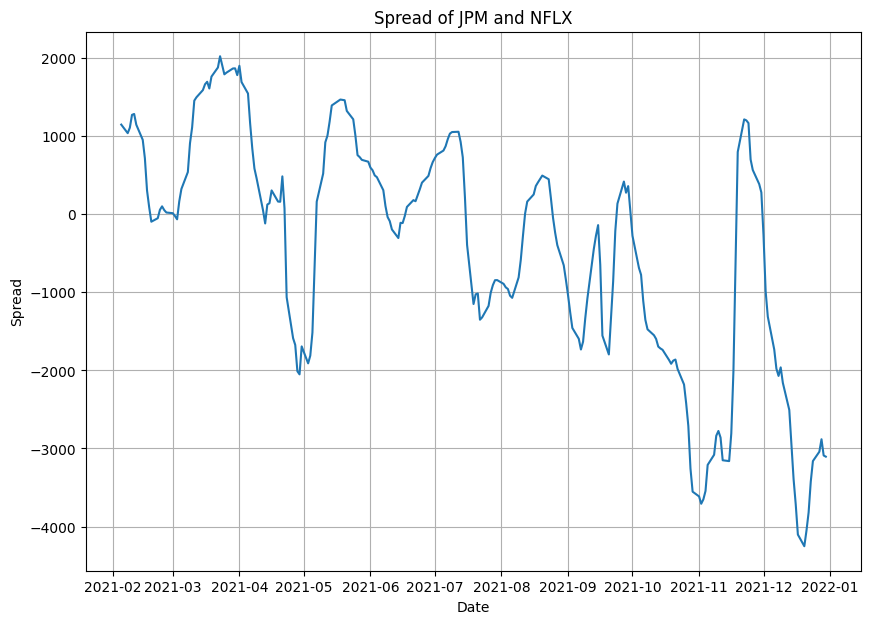

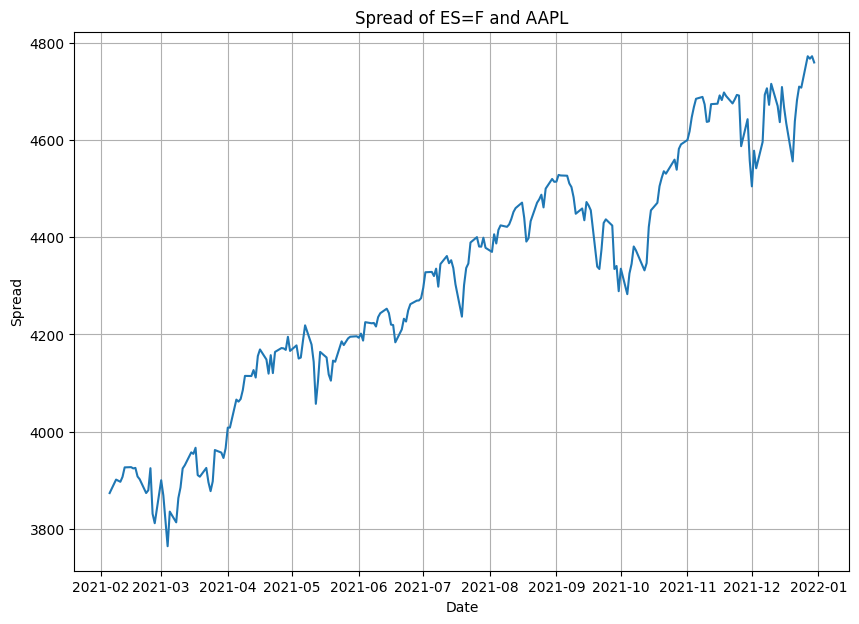

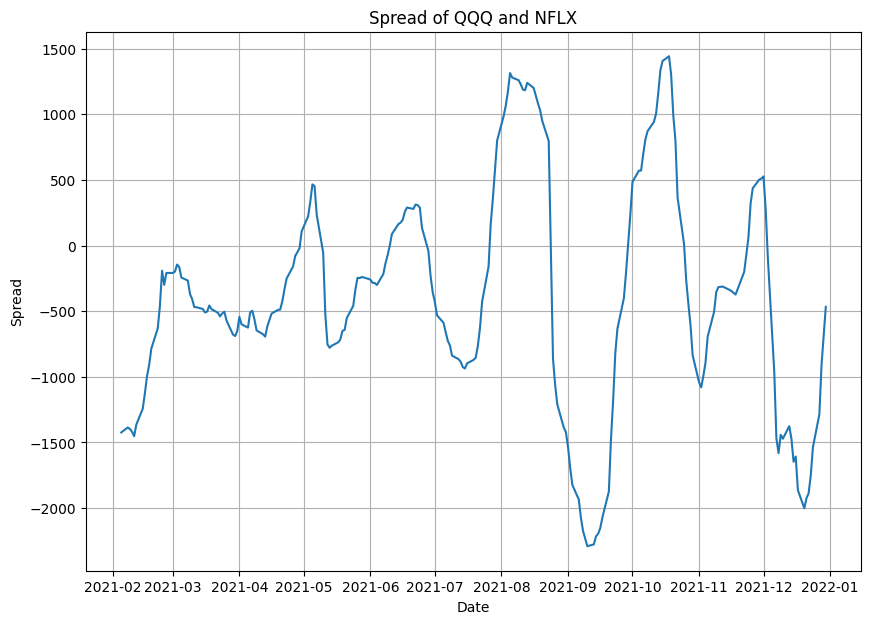

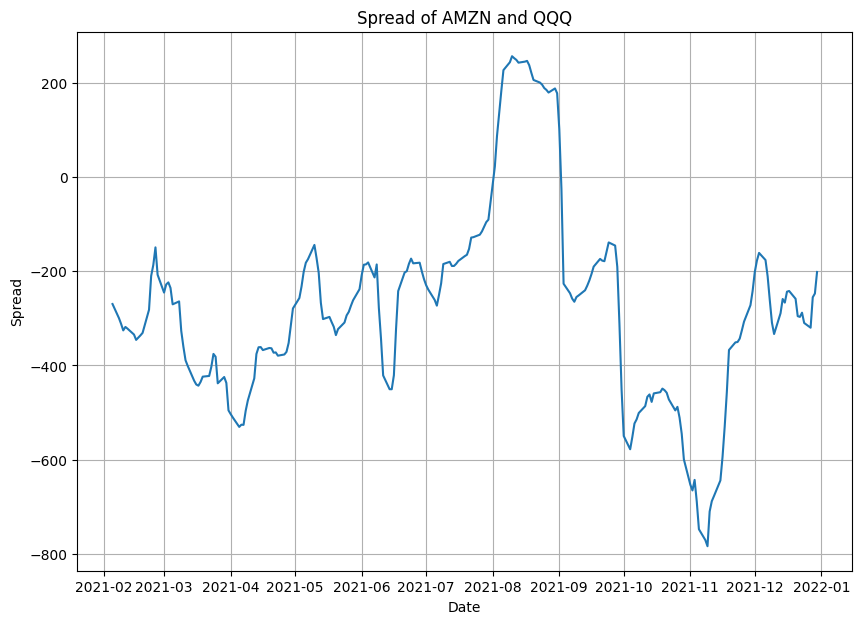

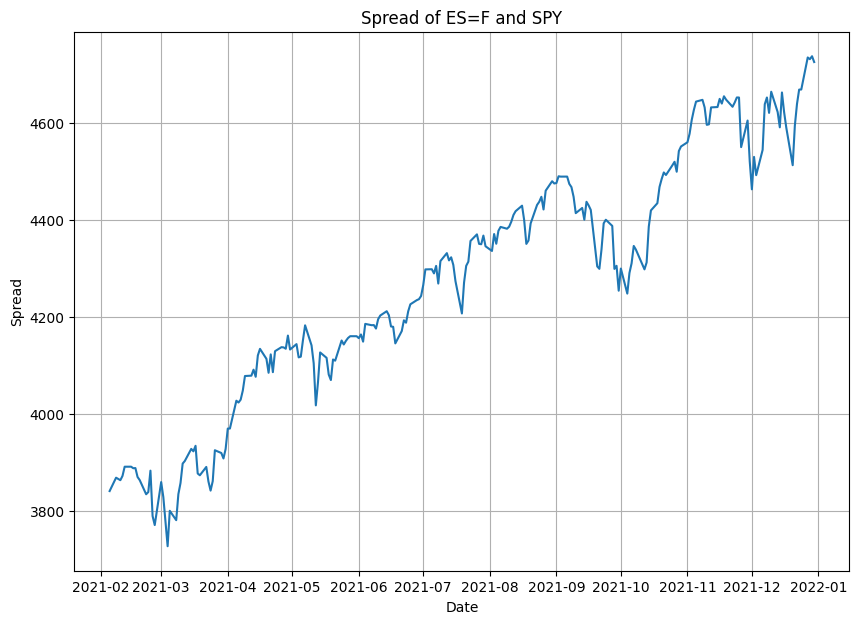

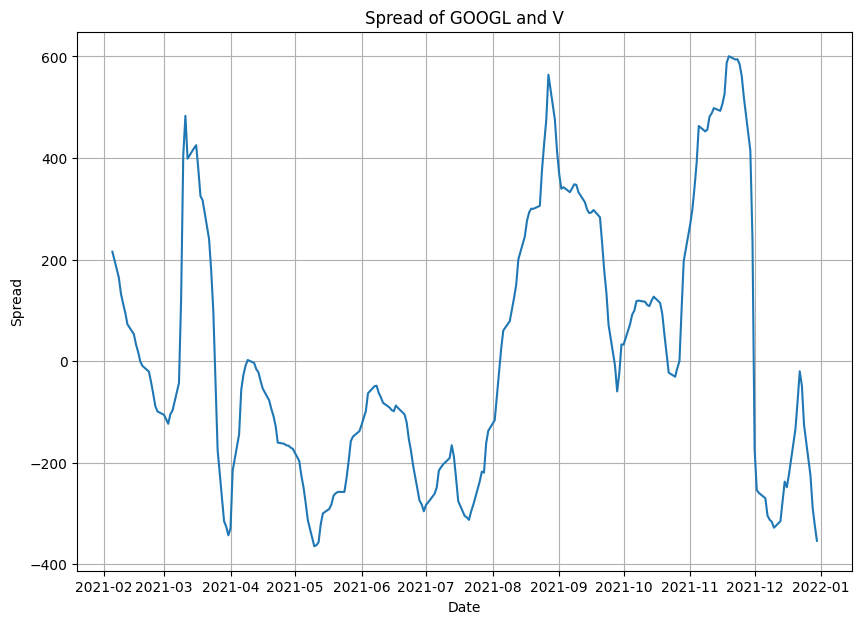

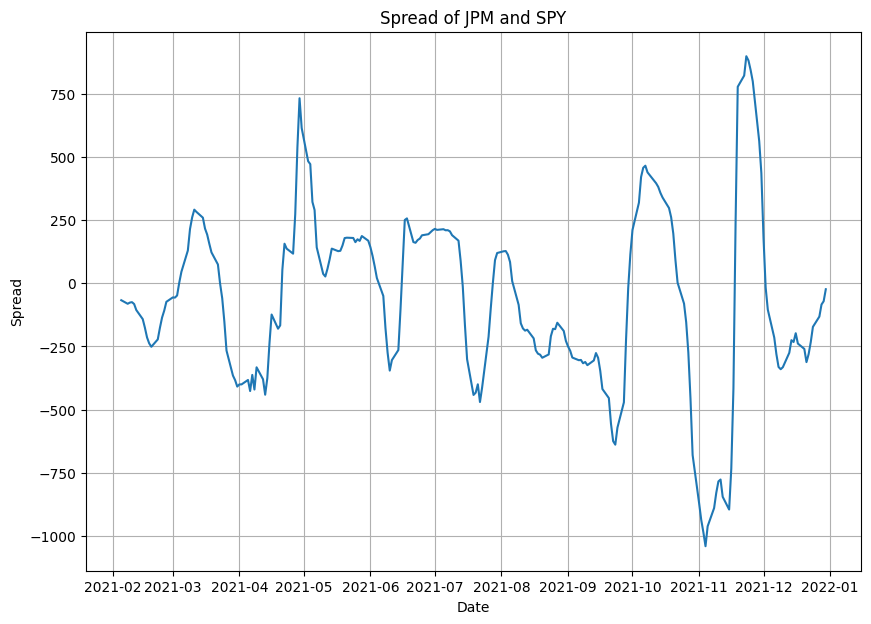

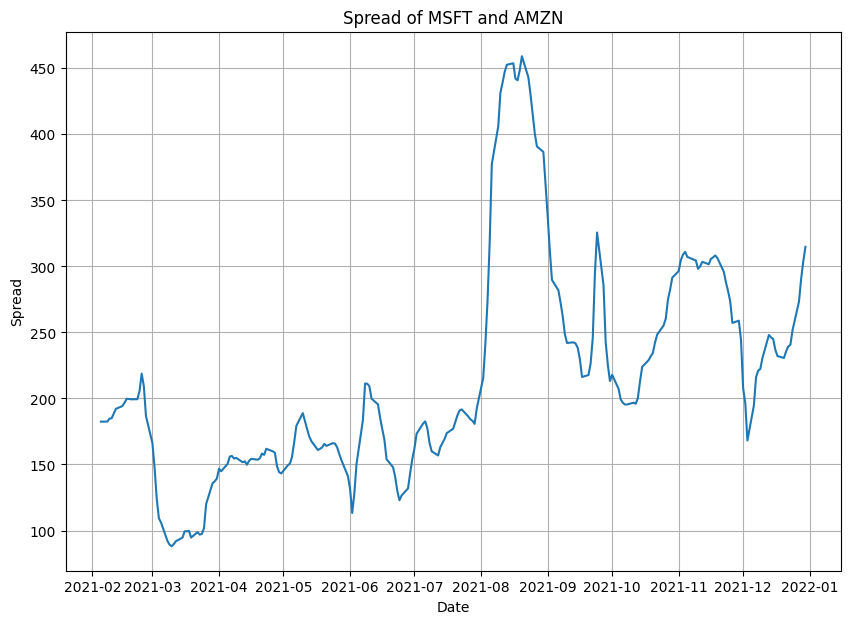

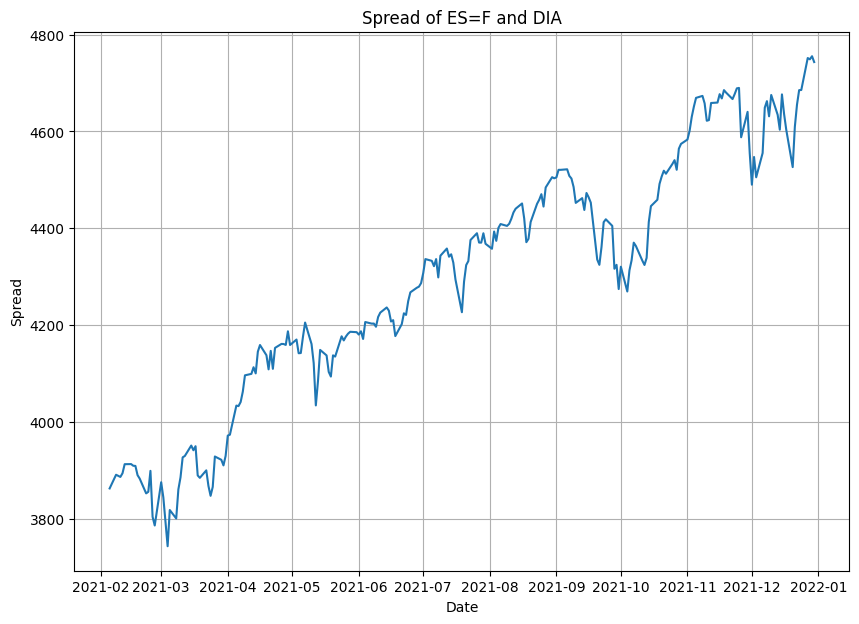

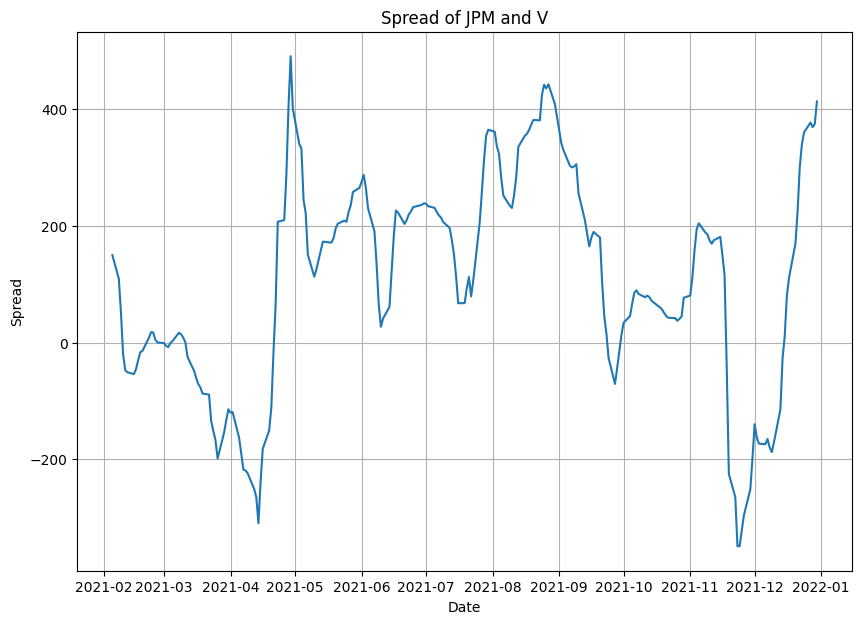

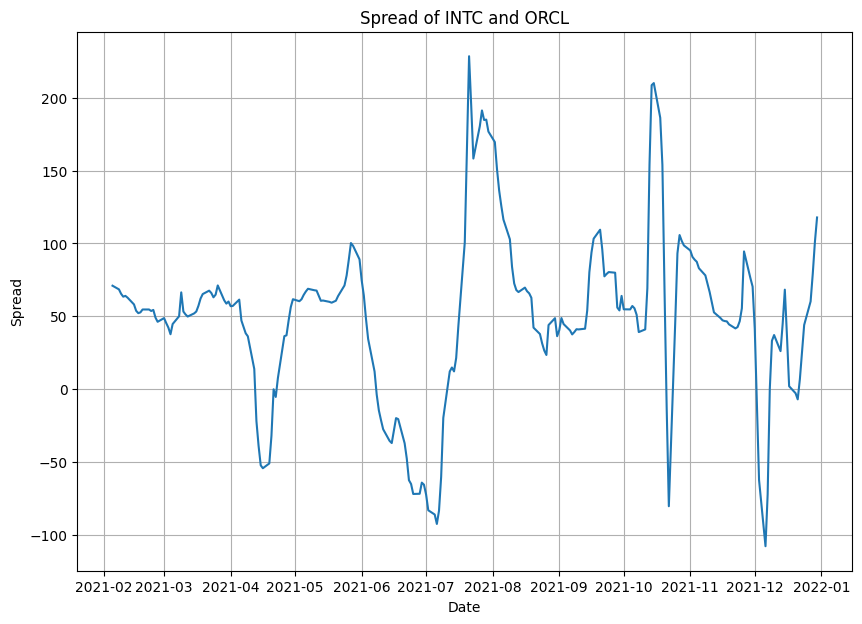

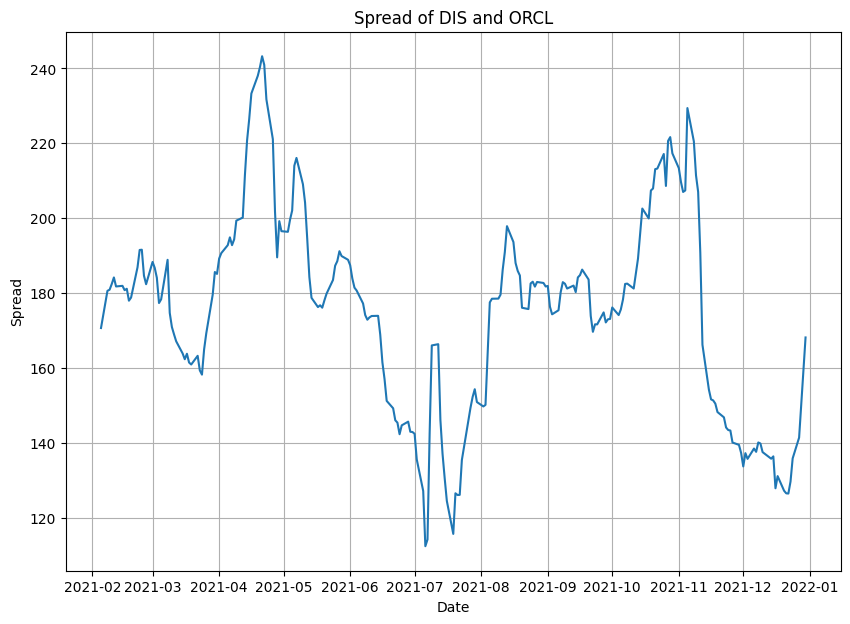

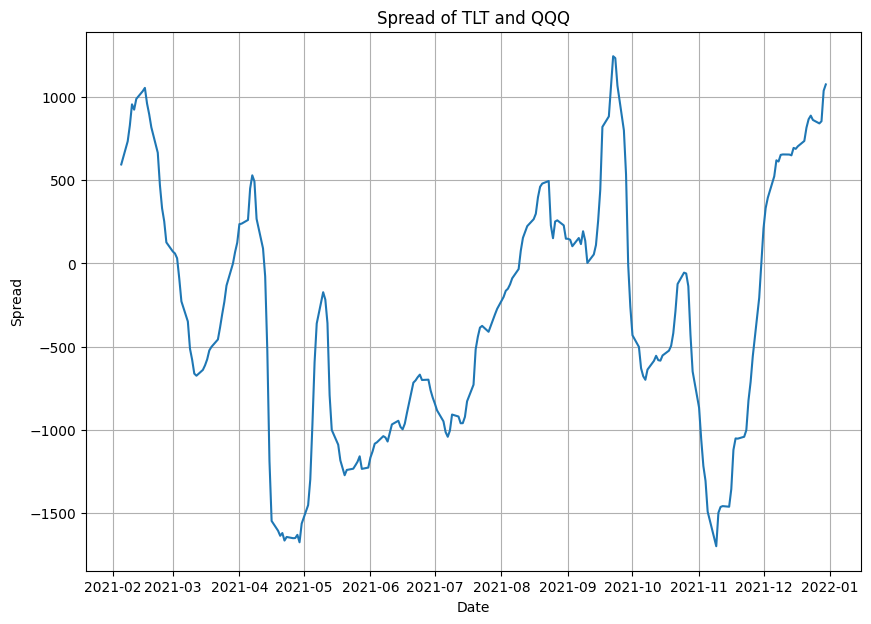

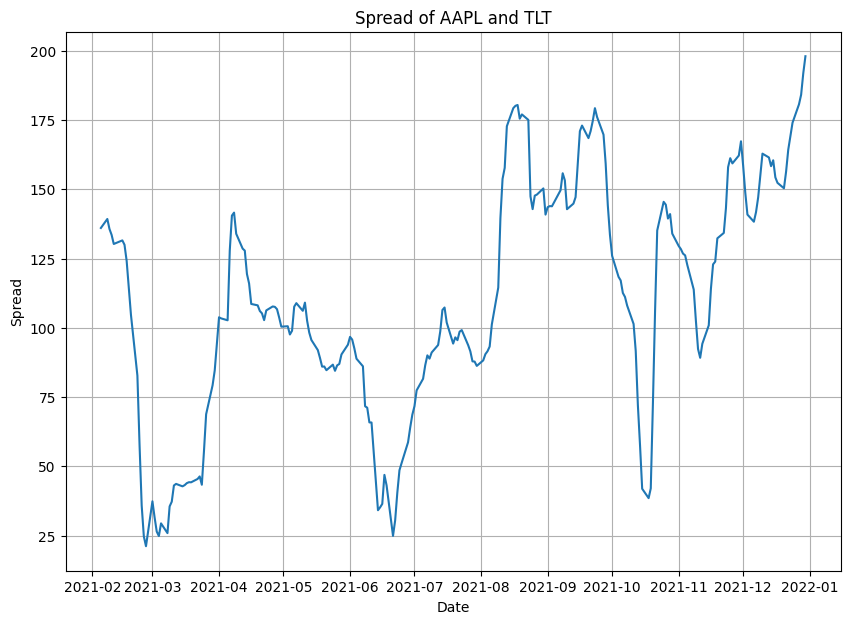

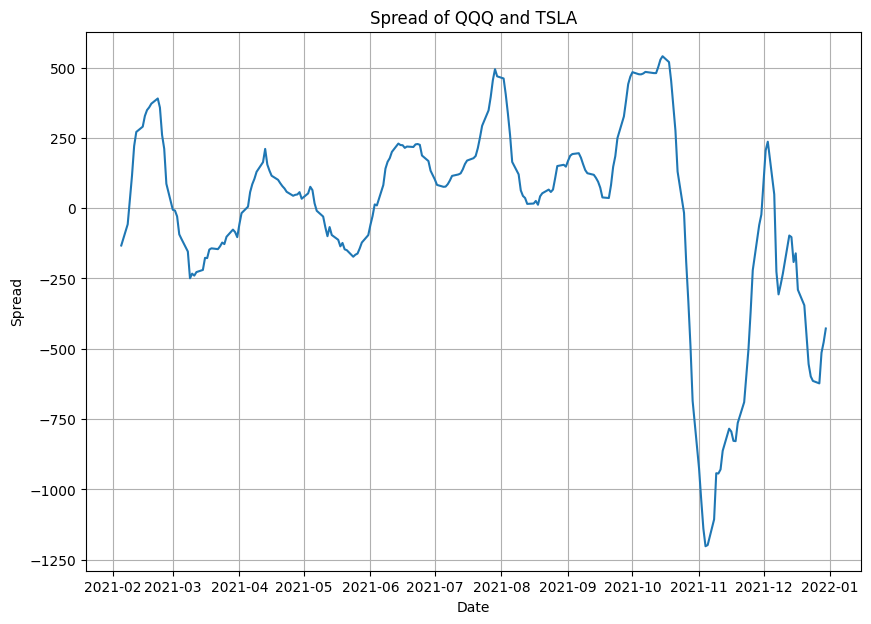

In [3]:
#Apply trading period
start_date = pd.Timestamp("2021-01-01")
end_date = pd.Timestamp("2021-12-31")
sharpe_ratios = []
# Compute and standardise the spread
for asset1, asset2, correlation, pvalue in filtered_pairs:    
    # Get the returns of the trading period
    asset1_trade = asset_data[asset_dict[asset1]].loc[start_date:end_date]
    asset2_trade = asset_data[asset_dict[asset2]].loc[start_date:end_date]
    prices1_trade = asset1_trade
    prices2_trade = asset2_trade
    min_len = min(len(prices1_trade), len(prices2_trade))
    prices1_trade = prices1_trade[:min_len]
    prices2_trade = prices2_trade[:min_len]


    #add rolling window
    prices1_trade_rolling = prices1_trade.rolling(25).mean().dropna()
    prices2_trade_rolling = prices2_trade.rolling(25).mean().dropna()
    # Compute spread during the testing period
    window_size = 25
    hedge_ratios = []
    model = LinearRegression()
    #Adding rolling regression
    for i in range(window_size, len(prices1_trade)):
        x = prices1_trade.iloc[i-window_size:i].values.reshape(-1,1)  # reshape for sklearn compatibility
        y = prices2_trade.iloc[i-window_size:i]
        model.fit(x, y)
        hedge_ratios.append(model.coef_[0])
        # Now hedge_ratios contains the coefficient of each window
    hedge_ratios = pd.Series(hedge_ratios, index=prices1_trade.index[window_size:])
   
    spread = (prices1_trade - hedge_ratios * prices2_trade)
    # Plot the spread
    plt.figure(figsize=(10,7))
    plt.plot(spread.index, spread.values)
    plt.title(f'Spread of {asset1} and {asset2}')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.grid(True)
    plt.show()
     #Rolling window for mean and std
    spread_mean = spread.rolling(25).mean().dropna()
    spread_std = spread.rolling(25).std().dropna()
    z_score = (spread - spread_mean) / spread_std

    # Generate trading strategy
    entry_threshold = 1.0
    exit_threshold = 0.0
    longs = (z_score <= -entry_threshold)
    shorts = (z_score >= entry_threshold)
    exits = ((z_score <= exit_threshold) & shorts) | ((z_score >= -exit_threshold) & longs)
    positions = pd.Series(data=0, index=longs.index)
    positions[longs] = 1
    positions[shorts] = -1
    positions[exits] = 0
    positions = positions.fillna(method='ffill')
   
    model = LinearRegression()
    model.fit(prices1_trade.values.reshape(-1,1), prices2_trade)
    hedge_ratio = model.coef_[0]
    spread_returns = (prices1_trade - hedge_ratio * prices2_trade)
    min_len = min(len(spread_returns), len(positions))
    spread_returns = spread_returns[:min_len]
    positions = positions[:min_len]
    daily_returns = positions.shift(2) * spread_returns
    daily_std = daily_returns.std()
    #Added epislon value, e, due to some std values being very small/close to 0
    e = 1e-8
    sharpe_ratio = np.sqrt(252) * daily_returns.mean() / (daily_std + e)
    sharpe_ratios.append(sharpe_ratio)

In [4]:
# Print and plot the top 20 pairs
for i, (name1, name2, correlation, pvalue) in enumerate(filtered_pairs):
    sharpe_ratio = sharpe_ratios[i]
    print(f"Pair {i+1}: {name1}, {name2}, Sharpe Ratio: {sharpe_ratio}, Correlation: {correlation}")

Pair 1: KO, ORCL, Sharpe Ratio: 0.05198757348292649, Correlation: 0.9283410444771478
Pair 2: MSFT, V, Sharpe Ratio: -0.5573696143294284, Correlation: 0.964415997744135
Pair 3: MSFT, TSLA, Sharpe Ratio: -2.0334200221655214, Correlation: 0.7827422048057975
Pair 4: MSFT, GOOGL, Sharpe Ratio: -1.1512864954556248, Correlation: 0.9347569068530501
Pair 5: GOOGL, AMZN, Sharpe Ratio: 0.29421673495027195, Correlation: 0.9559542849858841
Pair 6: JPM, DIA, Sharpe Ratio: -0.4220275497758236, Correlation: 0.9673457487758793
Pair 7: AMZN, V, Sharpe Ratio: 0.36098029784946983, Correlation: 0.9637768409421464
Pair 8: GOOGL, KO, Sharpe Ratio: -3.984149648596188, Correlation: 0.8828040869620553
Pair 9: MSFT, NFLX, Sharpe Ratio: -0.16285816060569064, Correlation: 0.9678137442078302
Pair 10: ES=F, QQQ, Sharpe Ratio: -9.065146651532448, Correlation: 0.9768981237696954
Pair 11: KO, DIS, Sharpe Ratio: -1.8897535202164017, Correlation: 0.9394953719791977
Pair 12: JPM, NFLX, Sharpe Ratio: -1.7119739633738822, C

In [5]:
#From results, best-performing pair is TLT and QQQ with sharpe ratio of 2.96
#Limitations:
    #Stationarity Assumption: The strategy assumes that the relationship between the two assets is stationary over time
    #Transaction Costs: The strategy assumes that trading can be executed without incurring significant transaction costs.
        #Can ignore for now
    #Risk Management: The code provided does not explicitly address risk management techniques, such as position sizing, stop-loss orders, or portfolio diversification